In [54]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
import matplotlib.pyplot as plt
import random

In [4]:
IMAGE_SHAPE = [32, 32, 3]

In [59]:
# Class map
class_map = {
    0: 'Airplane',
    1: 'Autombile',
    2: 'Bird',
    3: 'Cat',
    4: 'Deer',
    5: 'Dog',
    6: 'Frog',
    7: 'Horse',
    8: 'Ship',
    9: 'Truck',
}

In [5]:
## Mout your google drive
from google.colab import drive
## mount location
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Unbalance the dataset

In [29]:
train, test = tf.keras.datasets.cifar10.load_data()

In [30]:
# Print the class counts
# print(train[0].shape)
class_count_dict = {k: 0 for k in range(10)}
for lbl in train[1]:
  class_count_dict[lbl[0]] += 1
print(class_count_dict)

{0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000}


In [31]:
# Remove some data and make the dataset unbalance
# Remove from the following classes
# class 1: 300 -> 4700
# class 2: 1000 -> 4000
# class 4: 4500 -> 500
# class 7: 2000 -> 3000

count_1, count_2, count_4, count_7 = 0, 0, 0, 0
img_list, lbl_list = list(), list()

for img, lbl in zip(train[0], train[1]):
  if lbl[0] == 1:
    if count_1 < 300:
      count_1 += 1
      continue
    else:
      img_list.append(img)
      lbl_list.append(lbl)
  elif lbl[0] == 2:
    if count_2 < 1000:
      count_2 += 1
      continue
    else:
      img_list.append(img)
      lbl_list.append(lbl)
  elif lbl[0] == 4:
    if count_4 < 4500:
      count_4 += 1
      continue
    else:
      img_list.append(img)
      lbl_list.append(lbl)
  elif lbl[0] == 7:
    if count_7 < 2000:
      count_7 += 1
      continue
    else:
      img_list.append(img)
      lbl_list.append(lbl)
  else:
    img_list.append(img)
    lbl_list.append(lbl)

In [32]:
class_count_dict = {k: 0 for k in range(10)}

for lbl in lbl_list:
  class_count_dict[lbl[0]] += 1
print(class_count_dict)

{0: 5000, 1: 4700, 2: 4000, 3: 5000, 4: 500, 5: 5000, 6: 5000, 7: 3000, 8: 5000, 9: 5000}


In [33]:
def _bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

## Now this function is defined to structure one image sample
def image_example(image_string, label, image_shape):
  feature = {
      'height': _int64_feature(image_shape[0]),
      'width': _int64_feature(image_shape[1]),
      'depth': _int64_feature(image_shape[2]),
      'label': _int64_feature(label),
      'image_raw': _bytes_feature(image_string),
  }

  ## the structure of the features now looks like
  ## features = {
  ##    'height': int64_list {
  ##                          value: height_val
  ##                          },
  ##    'width': int64_list {
  ##                          value: width_val
  ##                          },
  ##    'depth': int64_list {
  ##                          value: depth_val
  ##                          },
  ##    'label': int64_list {
  ##                          value: label_val
  ##                          },
  ##    'image_raw': byte_list {
  ##                          value: image_data
  ##                          },
  ##            }
  #print(feature)
  ## What the tf.train.Example does is, it converts the strctured features into
  ## a protocol buffer
  ## tf.train.Example protobuf doc: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/example/example.proto
  return tf.train.Example(features=tf.train.Features(feature=feature))

In [34]:
# Dump a tfrecord
record_file = '/content/drive/My Drive/public_data/cifar_10/train/cifar_10_unbalanced.tfrecords'
with tf.io.TFRecordWriter(record_file) as writer:
    ## iterate over the  dataset (this is the case of keras.datasets API data)
    for data, lbl in zip(img_list, lbl_list):
        ## convert the uint8 image data to a binary string for storage
        ## The reason is, as the functions accepts only scalars, not lists or nd arrays,
        ## we must convert the list/array to a string of bytes
        bin_data = data.tobytes('C')
        ## Make a tf example protobuf from the given binarized image data and labels
        tf_example = image_example(bin_data, lbl, IMAGE_SHAPE)
        ## Write the serialized protobuf to record file
        writer.write(tf_example.SerializeToString())

## Balance the dataset

In [126]:
import albumentations as A

In [127]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10, 10))
  for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    # print(image_batch[n].shape)
    plt.imshow(np.uint8(image_batch[n]))# / 255.0)
    plt.title(class_map[label_batch[n]])
    '''
    if label_batch[n]:
        plt.title("MALIGNANT")
    else:
        plt.title("BENIGN")
    '''
    plt.axis("off")

In [128]:
def decode_image(image, height, width, depth):
    image = tf.io.decode_raw(image, out_type=tf.uint8)
    # image = tf.cast(image, tf.float32)
    image = tf.reshape(image, [height, width, depth]) 
    return image

In [129]:
## feature descriptor dict
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

## Now we make a function that an iterator can take as an higher oder function
def _parser_image_function(example_proto):
    ## Parse a single image feature structure
    ## serialized byte --> _parser_image_function(feature description) --> parsed image structure (see image_example function)
    example = tf.io.parse_single_example(example_proto, image_feature_description)
    image_decoded = decode_image(example['image_raw'], 32, 32, 3)
    label = example['label']

    return image_decoded, label

In [130]:
raw_image_dataset = tf.data.TFRecordDataset('/content/drive/My Drive/public_data/cifar_10/train/cifar_10_unbalanced.tfrecords')
parsed_image_dataset = raw_image_dataset.map(_parser_image_function)

In [131]:
class_count_dict = {k: 0 for k in range(10)}

# Count the number of samples for each class and 
for _, lbl in parsed_image_dataset:
  class_count_dict[lbl.numpy()] += 1
print(class_count_dict)

{0: 5000, 1: 4700, 2: 4000, 3: 5000, 4: 500, 5: 5000, 6: 5000, 7: 3000, 8: 5000, 9: 5000}


Text(0.5, 1.0, 'Class Balance')

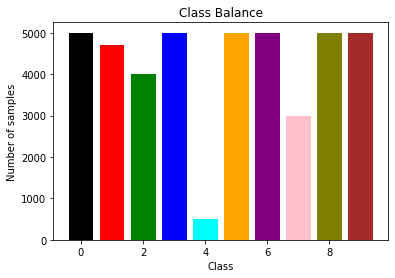

In [132]:
# Visualise
classes = list(class_count_dict.keys())
num_samples = list(class_count_dict.values())
plt.bar(classes, num_samples, color=['black', 'red', 'green', 'blue', 'cyan', 'orange', 'purple', 'pink', 'olive', 'brown'])
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.title("Class Balance")

In [133]:
# Determine the class with the largest number of samples and augment the other classes to have the same number of samples
max_num_samples = max(num_samples)
# for each class get the sample requirement
num_samples_to_balance_dict = {k: max_num_samples - v for k, v in class_count_dict.items()}

In [134]:
# Get the indices of each class to a dict
class_idx_dict = {k: [] for k in range(10)}
img_list = list()
label_list = list()

for i, (img, lbl) in enumerate(parsed_image_dataset):
  class_idx_dict[lbl.numpy()].append(i)
  img_list.append(img.numpy())
  label_list.append(lbl.numpy())

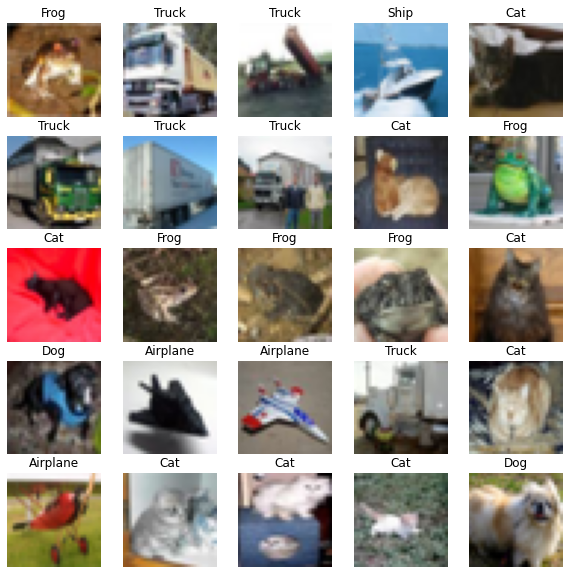

In [135]:
# Visualise some samples
show_batch(img_list, label_list)

In [136]:
#print(class_idx_dict[7])
np.random.choice(class_idx_dict[7])
print(label_list)

[6, 9, 9, 8, 3, 9, 9, 9, 3, 6, 3, 6, 6, 6, 3, 5, 0, 0, 9, 3, 0, 3, 3, 3, 5, 0, 9, 5, 9, 5, 3, 8, 9, 8, 5, 9, 6, 3, 9, 0, 3, 3, 5, 5, 9, 3, 8, 0, 6, 8, 3, 9, 6, 6, 8, 5, 9, 9, 8, 0, 0, 6, 9, 9, 6, 6, 9, 5, 0, 6, 8, 8, 3, 3, 6, 9, 9, 5, 3, 6, 6, 8, 5, 5, 3, 8, 6, 0, 9, 5, 3, 8, 5, 3, 5, 0, 5, 5, 0, 9, 6, 9, 0, 8, 8, 8, 5, 3, 5, 0, 6, 9, 3, 6, 9, 3, 9, 6, 6, 0, 9, 5, 8, 5, 9, 0, 8, 8, 0, 6, 9, 6, 3, 6, 6, 0, 6, 6, 5, 8, 3, 6, 6, 8, 6, 8, 6, 6, 3, 8, 3, 3, 8, 5, 0, 9, 3, 9, 9, 9, 9, 0, 5, 9, 0, 8, 0, 5, 6, 3, 8, 8, 6, 0, 9, 5, 6, 5, 9, 9, 0, 8, 6, 3, 3, 9, 0, 9, 9, 5, 6, 6, 8, 3, 0, 3, 3, 5, 5, 9, 0, 3, 0, 6, 0, 0, 6, 6, 0, 8, 6, 9, 5, 9, 6, 8, 3, 6, 9, 3, 0, 0, 5, 0, 3, 8, 5, 3, 9, 6, 0, 3, 8, 0, 0, 0, 9, 0, 9, 6, 8, 0, 3, 0, 8, 9, 5, 5, 9, 8, 5, 0, 6, 9, 0, 8, 8, 9, 9, 3, 3, 0, 5, 6, 6, 0, 0, 8, 0, 8, 8, 5, 6, 8, 0, 0, 5, 9, 6, 8, 3, 3, 9, 0, 8, 8, 6, 5, 3, 9, 8, 0, 5, 8, 8, 0, 8, 9, 8, 9, 9, 5, 3, 8, 8, 6, 0, 6, 9, 6, 5, 5, 9, 5, 8, 3, 3, 6, 9, 8, 0, 6, 0, 8, 0, 8, 8, 5, 6, 5, 8, 9, 9, 

In [137]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=1, contrast_limit=1, p=0.5),
])

# Dict to hold the augmented dataset
aug_img_list = list()
aug_lbl_list = list()

num_aug_samples_dict = dict()

# Augment the images with the requried number of samples and make a new dataset
for k, v in num_samples_to_balance_dict.items():
  aug_count = 0
  if v > 0:
    for t in range(v):
      # Randomly sample an image
      idx = np.random.choice(class_idx_dict[k])
      img = img_list[idx]
      # Apply the augmentation
      aug_img = transform(image=img)["image"]
      aug_img_list.append(aug_img)
      aug_lbl_list.append(k)
      aug_count += 1

  num_aug_samples_dict[k] = aug_count

In [138]:
num_aug_samples_dict

{0: 0, 1: 300, 2: 1000, 3: 0, 4: 4500, 5: 0, 6: 0, 7: 2000, 8: 0, 9: 0}

In [139]:
# Merge the two datasets (original + augmented)
img_list.extend(aug_img_list)
label_list.extend(aug_lbl_list)

# Shuffle the order
list_to_shuffle = list(zip(img_list, label_list))
random.shuffle(list_to_shuffle)
img_list, label_list = zip(*list_to_shuffle)

{0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000}


Text(0.5, 1.0, 'Class Balance')

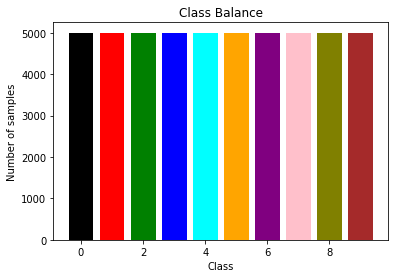

In [140]:
# Visualise
# Count the number of samples for each class and 
class_count_dict_balanced = {k: 0 for k in range(10)}

for lbl in label_list:
  class_count_dict_balanced[lbl] += 1
print(class_count_dict_balanced)

classes = list(class_count_dict_balanced.keys())
num_samples = list(class_count_dict_balanced.values())
plt.bar(classes, num_samples, color=['black', 'red', 'green', 'blue', 'cyan', 'orange', 'purple', 'pink', 'olive', 'brown'])
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.title("Class Balance")

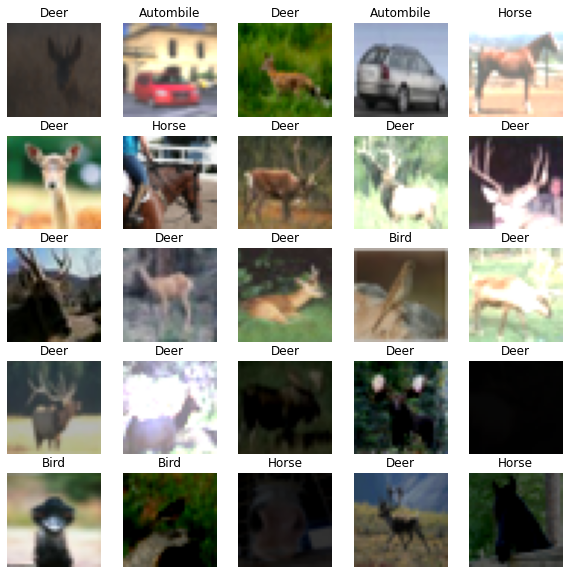

In [141]:
# Visualise some augmened samples
# Shuffle the order
list_to_shuffle = list(zip(aug_img_list, aug_lbl_list))
random.shuffle(list_to_shuffle)
aug_img_list, aug_lbl_list = zip(*list_to_shuffle)

show_batch(aug_img_list, aug_lbl_list)

## EXERCISE-1: 
### Add additional augmentations and prepare yourself a tfrecord file. 
### Ref: https://albumentations.ai/docs/getting_started/image_augmentation/

## EXERCISE-2:
### Train 2 VGG-16 models; one with unbalanced data and the other one with the balanced data; compare the confusion matrices (focus on the unbalanced classes)